In [2]:
import pandas as pd
import os 
import glob
import geopandas as gpd
import matplotlib.pyplot as plt

Combine into a single csv, note fraction of 0.1 as it is 350 gb of files

In [ ]:

import time

start_time = time.time()
out_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots'
os.makedirs(out_path, exist_ok = True)

# Specify the folder containing the CSV files
folder_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/anna_ndsi_csvs'

# Get a list of all CSV files in the folder
csv_files = glob.glob(f'{folder_path}/*.csv')

# Read all CSV files into a list of DataFrames
# dataframes = [pd.read_csv(file).sample(frac=0.2, random_state=1) for file in csv_files]

dataframes  =[]

for f in csv_files:

    df = pd.read_csv(f)

    columns_to_consider = df.iloc[:, :-3]

    # Finding the column with the maximum non-NA value for each row
    max_column = columns_to_consider.idxmax(axis=1)
    
    # Adding the result as a new column to the dataframe
    df['max_column'] = max_column

    df = df[['lat', 'lon', 'y', 'max_column']]

    # df = df.sample(frac = 0.4)
    # Filter rows where 'y' is 0
    df_0 = df[df['y'] == 0]
    
    # Filter rows where 'y' is 1
    df_1 = df[df['y'] == 1]
    
    # Sample 20% from each
    df_0_sample = df_0.sample(frac=0.2, random_state=42)
    df_1_sample = df_1.sample(frac=0.2, random_state=42)
    
    # Combine the samples back together
    df_sampled = pd.concat([df_0_sample, df_1_sample])

    dataframes.append(df_sampled)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.to_parquet(os.path.join(out_path, 'combined_file_sampled.parquet'), index=False, engine='pyarrow')
combined_df.head()

# Record the end time
end_time = time.time()

# Calculate the elapsed time in seconds
elapsed_time_seconds = end_time - start_time

# Convert elapsed time to hours
elapsed_time_hours = elapsed_time_seconds / 3600  # 3600 seconds in an hour

print(f"Script took {elapsed_time_hours:.2f} hours to run.")


In [8]:
't'

't'

In [6]:
combined_df

NameError: name 'combined_df' is not defined

With dask

In [10]:
import os
import glob
import pandas as pd
import dask.dataframe as dd
from dask import delayed
import time

start_time = time.time()

#iif want to set workers
# from dask.distributed import Client, LocalCluster

# # Create a local cluster with a specified number of workers (cores)
# cluster = LocalCluster(n_workers=4, threads_per_worker=2)
# client = Client(cluster)

out_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots'
os.makedirs(out_path, exist_ok=True)

folder_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/anna_ndsi_csvs'
csv_files = glob.glob(f'{folder_path}/*.csv')

@delayed
def process_file(f):
    df = pd.read_csv(f)
    columns_to_consider = df.iloc[:, :-3]
    max_column = columns_to_consider.idxmax(axis=1)
    df['max_column'] = max_column
    df = df[['lat', 'lon', 'y', 'max_column']]
    
    df_0_sample = df[df['y'] == 0].sample(frac=0.2, random_state=42)
    df_1_sample = df[df['y'] == 1].sample(frac=0.2, random_state=42)
    
    df_sampled = pd.concat([df_0_sample, df_1_sample])
    
    return df_sampled

# Use Dask to parallelize the processing
dataframes = [process_file(f) for f in csv_files]
combined_df = dd.from_delayed(dataframes).compute()

combined_df.to_parquet(os.path.join(out_path, 'combined_file_sampled_dask.parquet'), index=False, engine='pyarrow')
combined_df.head()


# Record the end time
end_time = time.time()

# Calculate the elapsed time in seconds
elapsed_time_seconds = end_time - start_time

# Convert elapsed time to hours
elapsed_time_hours = elapsed_time_seconds / 3600  # 3600 seconds in an hour

print(f"Script took {elapsed_time_hours:.2f} hours to run.")


Script took 1.60 hours to run.


In [2]:
import pandas as pd
df = pd.read_parquet('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/combined_file_sampled.parquet')

df.head()

,lat,lon,y,max_column
0,56.712575,102.066089,0,999
1,56.780488,101.873939,0,152
2,56.779949,101.955326,0,152
3,56.751652,102.071209,0,999
4,56.784800,102.044529,0,212


In [ ]:
import pandas as pd
df = pd.read_parquet('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/combined_file_sampled_dask.parquet')

# Convert 'max_column' to integer
df['max_column'] = df['max_column'].astype(int)

# Split the DataFrame into two based on the value 999 in 'max_column'
df_not_999 = df[df['max_column'] != 999].copy()
df_999 = df[df['max_column'] == 999].copy()

# Find the minimum and maximum of 'max_column' in the non-999 DataFrame
min_value = df_not_999['max_column'].min()
max_value = df_not_999['max_column'].max()

# Create a new column 'interval' with bins of 30
bins = list(range(min_value - (min_value % 30), max_value + 30, 30))
labels = [f"{i}-{i + 30}" for i in bins[:-1]]
df_not_999['interval'] = pd.cut(df_not_999['max_column'], bins=bins, labels=labels, right=False)

# Calculate the middle value of each interval
df_not_999['interval_mid'] = df_not_999['interval'].apply(lambda x: (int(x.split('-')[0]) + int(x.split('-')[1])) // 2)

df_not_999.head()

#make the interval for 999 and midpoint 999
df_999['interval'] = '999-999'
df_999['interval_mid'] = -1

#concat
df_final = pd.concat([df_not_999, df_999], ignore_index = True)

#split 1s and 0s
df_1 = df_final[df_final['y'] != 0]
df_0 = df_final[df_final['y'] == 0]


df_1.head()

In [23]:
df_1.tail()

,lat,lon,y,max_column,interval,interval_mid
1372592317,59.261725,135.020425,1,999,999-999,-1
1372592318,59.251484,135.018808,1,999,999-999,-1
1372592319,59.257413,135.012610,1,999,999-999,-1
1372592320,59.256335,135.027702,1,999,999-999,-1
1372592321,59.259569,135.030127,1,999,999-999,-1


In [2]:
't'

't'

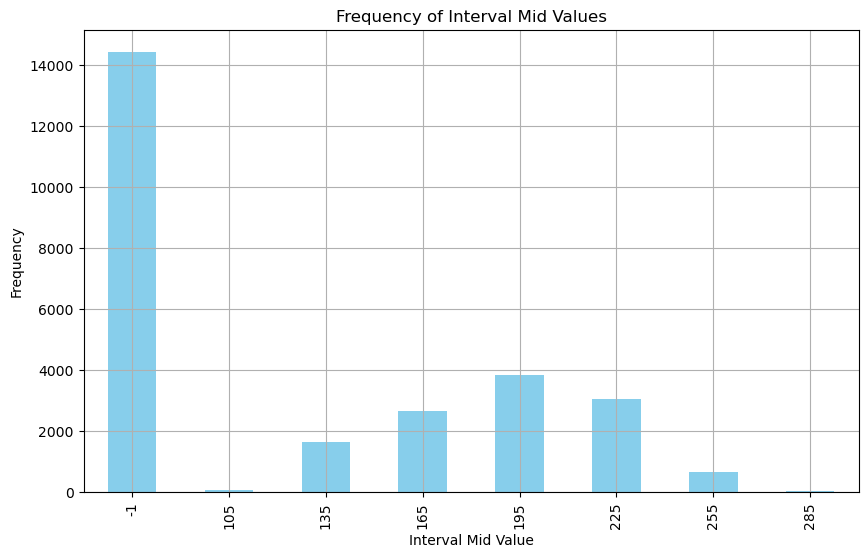

In [14]:
import matplotlib.pyplot as plt

# Create a frequency plot of the interval_mid values
plt.figure(figsize=(10, 6))
df_1['interval_mid'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Interval Mid Value')
plt.ylabel('Frequency')
plt.title('Frequency of Interval Mid Values')
plt.grid(True)
plt.show()

Save frequency plots for 1s

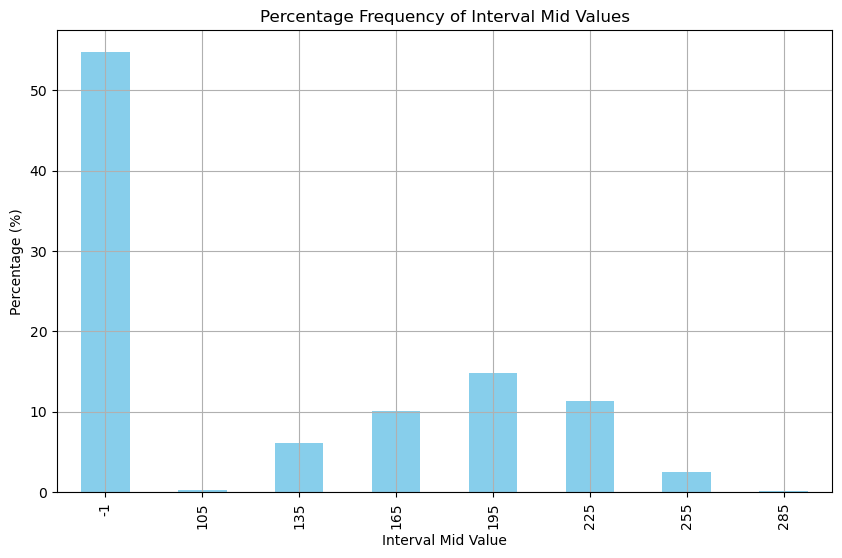

In [5]:
import matplotlib.pyplot as plt
import os

out_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/frequencies'
os.makedirs(out_path, exist_ok = True)

# Calculate the percentage frequency of each interval_mid value
interval_mid_percentage = (df_1['interval_mid'].value_counts(normalize=True) * 100).sort_index()

# Create a percentage frequency plot
plt.figure(figsize=(10, 6))
interval_mid_percentage.plot(kind='bar', color='skyblue')
plt.xlabel('Interval Mid Value')
plt.ylabel('Percentage (%)')
plt.title('Percentage Frequency of Interval Mid Values')
plt.grid(True)

# Save the plot as a PNG file
plt.savefig(os.path.join(out_path, 'interval_mid_percentage_plot_1.png'))
plt.show()

Save frequency plots for 0s

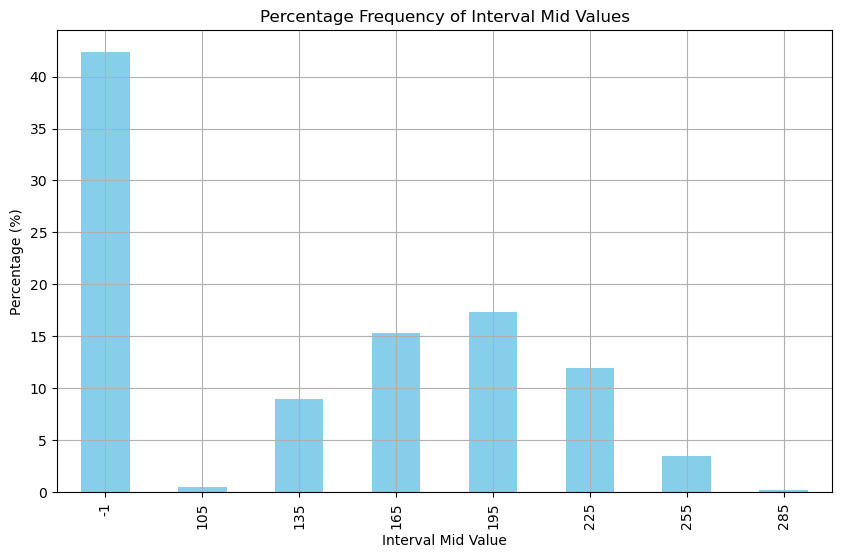

In [6]:
out_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/frequencies'
os.makedirs(out_path, exist_ok = True)

# Calculate the percentage frequency of each interval_mid value
interval_mid_percentage = (df_0['interval_mid'].value_counts(normalize=True) * 100).sort_index()

# Create a percentage frequency plot
plt.figure(figsize=(10, 6))
interval_mid_percentage.plot(kind='bar', color='skyblue')
plt.xlabel('Interval Mid Value')
plt.ylabel('Percentage (%)')
plt.title('Percentage Frequency of Interval Mid Values')
plt.grid(True)

# Save the plot as a PNG file
plt.savefig(os.path.join(out_path, 'interval_mid_percentage_plot_0.png'))
plt.show()

Make geodataframe and save to use to find maximum occuring mid point value to in fishnet grid.  Probably zonal stats in arc for this

In [3]:
df_0.shape, df_1.shape

((1189193603, 6), (183398719, 6))

In [24]:
import geopandas as gpd
from shapely.geometry import Point

df_0_t = df_0.sample(700000, random_state = 42)
df_1_t = df_1.sample(700000, random_state = 42)

#gdf for 0s
geometry_0 = [Point(xy) for xy in zip(df_0_t['lon'], df_0_t['lat'])]
gdf_0 = gpd.GeoDataFrame(df_0_t, geometry=geometry_0)
gdf_0.set_crs(epsg=4326, inplace=True)
gdf_0.to_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/gdf_0.shp')


#gdf for 1s
geometry_1 = [Point(xy) for xy in zip(df_1_t['lon'], df_1_t['lat'])]
gdf_1 = gpd.GeoDataFrame(df_1_t, geometry=geometry_1)
gdf_1.set_crs(epsg=4326, inplace=True)
gdf_1.to_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/gdf_1.shp')


/tmp/ipykernel_2525263/4210597535.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_0.to_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/gdf_0.shp')
/tmp/ipykernel_2525263/4210597535.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_1.to_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/gdf_1.shp')


In [25]:
't'

't'

Run zonal stats

In [32]:
# Load the zones shapefile
zones = gpd.read_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ea_grid_clip/ea_grid_clip.shp')

# Ensure the zones GeoDataFrame is in the same CRS (EPSG 4326)
zones = zones.to_crs(epsg=4326)

# Perform the intersection between the zones and gdf
intersected_gdf = gpd.overlay(gdf_0, zones, how='intersection')

# Group by the 'Id' column (from zones) and calculate the most frequent 'max_value' in each zone
most_frequent_max_value = intersected_gdf.groupby('Id')['interval_mid'].agg(lambda x: x.value_counts().idxmax())

# Create a new GeoDataFrame with the results
result_gdf = zones.merge(most_frequent_max_value, on='Id')

# Save the result to a new shapefile if needed
result_gdf.to_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/zone_most_frequent_max_value_0.shp')

# Display the result
print(result_gdf.head())

   Id                                           geometry  interval_mid
0   0  POLYGON ((100.00000 60.00000, 100.00000 55.000...            -1
1   4  POLYGON ((150.00000 60.00000, 150.00000 59.699...            -1
2  10  MULTIPOLYGON (((161.38889 69.45915, 161.37877 ...            -1
3  11  MULTIPOLYGON (((130.00000 50.26354, 130.00000 ...            -1
4  13  POLYGON ((160.00000 69.75901, 160.00000 65.000...            -1


/tmp/ipykernel_2525263/506642151.py:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result_gdf.to_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/zone_most_frequent_max_value_0.shp')


In [27]:
# Load the zones shapefile
zones = gpd.read_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ea_grid_clip/ea_grid_clip.shp')

# Ensure the zones GeoDataFrame is in the same CRS (EPSG 4326)
zones = zones.to_crs(epsg=4326)

# Perform the intersection between the zones and gdf
intersected_gdf = gpd.overlay(gdf_1, zones, how='intersection')

# Group by the 'Id' column (from zones) and calculate the most frequent 'max_value' in each zone
most_frequent_max_value = intersected_gdf.groupby('Id')['interval_mid'].agg(lambda x: x.value_counts().idxmax())

# Create a new GeoDataFrame with the results
result_gdf = zones.merge(most_frequent_max_value, on='Id')

# Save the result to a new shapefile if needed
result_gdf.to_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/zone_most_frequent_max_value_1.shp')

# Display the result
print(result_gdf.head())

   Id                                           geometry  interval_mid
0   0  POLYGON ((100.00000 60.00000, 100.00000 55.000...            -1
1   4  POLYGON ((150.00000 60.00000, 150.00000 59.699...           195
2  10  MULTIPOLYGON (((161.38889 69.45915, 161.37877 ...            -1
3  11  MULTIPOLYGON (((130.00000 50.26354, 130.00000 ...            -1
4  13  POLYGON ((160.00000 69.75901, 160.00000 65.000...            -1


/tmp/ipykernel_2525263/3603674860.py:17: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result_gdf.to_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/zone_most_frequent_max_value_1.shp')


In [21]:
gdf_1.head()

,lat,lon,y,max_column,interval,interval_mid,geometry
956398862,55.496885,94.013860,1,999,999-999,-1,POINT (94.01386 55.49689)
1044650705,66.143269,117.622933,1,999,999-999,-1,POINT (117.62293 66.14327)
697088749,64.091337,168.395713,1,212,210-240,225,POINT (168.39571 64.09134)
1293956977,68.311083,152.242746,1,999,999-999,-1,POINT (152.24275 68.31108)
1184484638,52.799514,118.473997,1,999,999-999,-1,POINT (118.47400 52.79951)


In [17]:
intersected_gdf.shape, gdf_1.shape

((698226, 8), (700000, 7))

Instead pick 3 areas on the south and 3 in the north and look at fequencies again

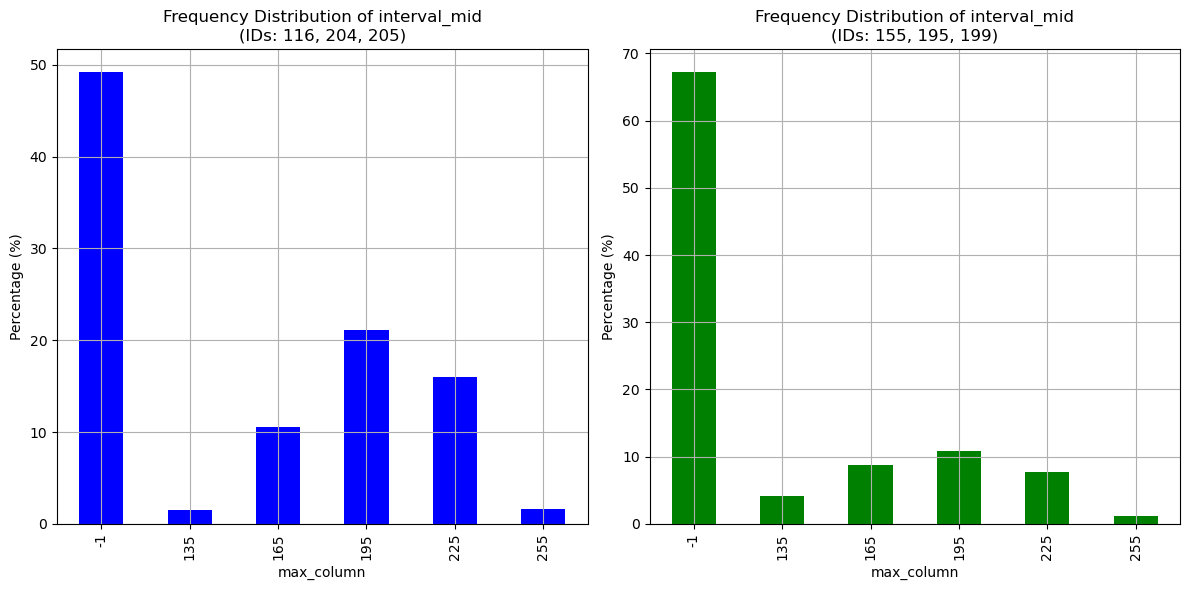

In [31]:
import matplotlib.pyplot as plt
import os

out_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/frequencies'
os.makedirs(out_path, exist_ok = True)

# Filter the intersected GeoDataFrame for the two groups of IDs
group_1 = intersected_gdf[intersected_gdf['Id'].isin([116, 122, 187])]
group_2 = intersected_gdf[intersected_gdf['Id'].isin([104, 134, 183])]

# Calculate the percentage frequency distribution for max_column in each group
group_1_freq = (group_1['interval_mid'].value_counts(normalize=True) * 100).sort_index()
group_2_freq = (group_2['interval_mid'].value_counts(normalize=True) * 100).sort_index()

# Plot the frequency distributions as bar plots
plt.figure(figsize=(12, 6))

# Plot for Group 1 (IDs: 116, 204, 205)
plt.subplot(1, 2, 1)
group_1_freq.plot(kind='bar', color='blue')
plt.title('Frequency Distribution of interval_mid\n(IDs: 116, 204, 205)')
plt.xlabel('max_column')
plt.ylabel('Percentage (%)')
plt.grid(True)

# Plot for Group 2 (IDs: 155, 195, 199)
plt.subplot(1, 2, 2)
group_2_freq.plot(kind='bar', color='green')
plt.title('Frequency Distribution of interval_mid\n(IDs: 155, 195, 199)')
plt.xlabel('max_column')
plt.ylabel('Percentage (%)')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(out_path, 'interval_mid_south_v_north_percentage_plot_1.png'))

plt.show()

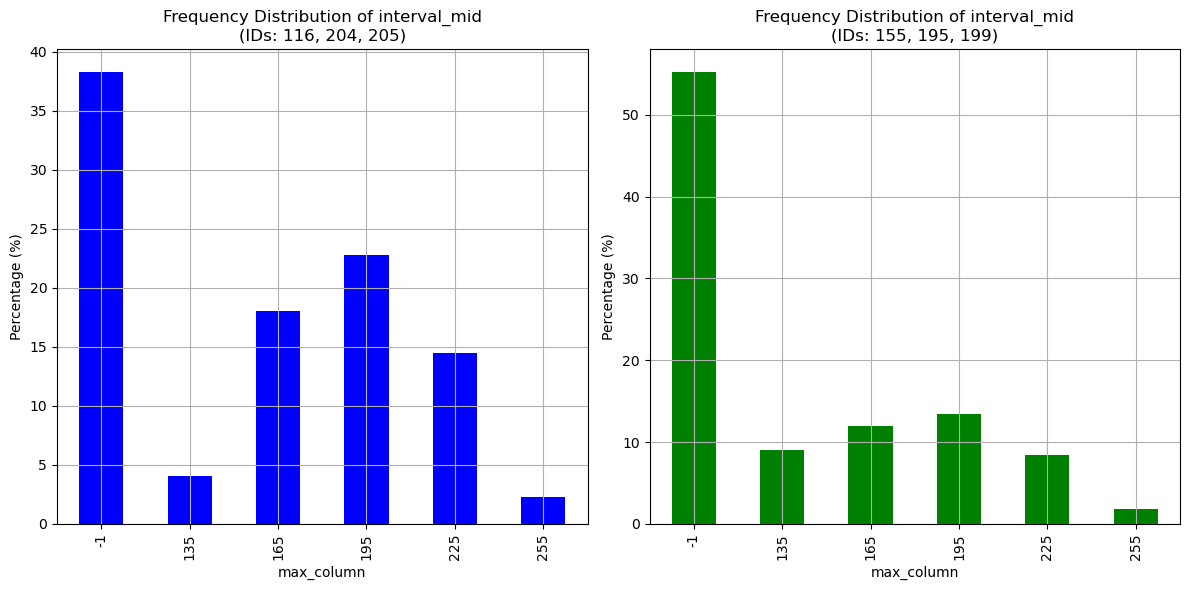

In [33]:
import matplotlib.pyplot as plt
import os

out_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/frequencies'
os.makedirs(out_path, exist_ok = True)

# Filter the intersected GeoDataFrame for the two groups of IDs
group_1 = intersected_gdf[intersected_gdf['Id'].isin([116, 122, 187])]
group_2 = intersected_gdf[intersected_gdf['Id'].isin([104, 134, 183])]

# Calculate the percentage frequency distribution for max_column in each group
group_1_freq = (group_1['interval_mid'].value_counts(normalize=True) * 100).sort_index()
group_2_freq = (group_2['interval_mid'].value_counts(normalize=True) * 100).sort_index()

# Plot the frequency distributions as bar plots
plt.figure(figsize=(12, 6))

# Plot for Group 1 (IDs: 116, 204, 205)
plt.subplot(1, 2, 1)
group_1_freq.plot(kind='bar', color='blue')
plt.title('Frequency Distribution of interval_mid\n(IDs: 116, 204, 205)')
plt.xlabel('max_column')
plt.ylabel('Percentage (%)')
plt.grid(True)

# Plot for Group 2 (IDs: 155, 195, 199)
plt.subplot(1, 2, 2)
group_2_freq.plot(kind='bar', color='green')
plt.title('Frequency Distribution of interval_mid\n(IDs: 155, 195, 199)')
plt.xlabel('max_column')
plt.ylabel('Percentage (%)')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(out_path, 'interval_mid_south_v_north_percentage_plot_0.png'))

plt.show()

Now do ecoregions

In [3]:
gdf_0 = gpd.read_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/gdf_0.shp')
gdf_1 = gpd.read_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/gdf_1.shp')
zones = gpd.read_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/cv_results_t2/ecoregion/shapefiles_final/Combined.shp')
zones.head()

,FID,Model,IOU,na_russ_IO,na_russ_85,na_russ_nd,combined_r,combined_1,combined_2,na_85_diff,na_ndsi_di,na_85_ndsi,combined_8,combined_n,combined_3,russ_85_di,russ_ndsi_,russ_85_nd,geometry
0,Arctic Deserts and Tundra,Combined,0.67,-0.12,-0.07,-0.03,0.03,-0.21,-0.02,0.25,-0.01,-0.26,-0.04,-0.15,-0.11,0.20,-0.10,-0.30,"MULTIPOLYGON (((-172.67568 64.65704, -172.6414..."
1,Central Taiga,Combined,0.77,0.01,-0.06,-0.05,-0.01,-0.09,-0.03,0.04,0.06,0.02,0.03,0.10,0.07,0.11,0.12,0.01,"MULTIPOLYGON (((31.70963 61.37057, 31.70542 61..."
2,Montane Boreal,Combined,0.68,-0.07,-0.06,0.00,-0.09,-0.09,0.03,0.06,0.00,-0.06,0.05,0.05,0.00,0.05,-0.07,-0.12,"MULTIPOLYGON (((111.21264 54.01246, 111.20121 ..."
3,Montane Sub-Arctic,Combined,0.82,-0.04,-0.04,-0.06,-0.05,-0.06,-0.04,0.05,0.06,0.01,0.04,0.09,0.05,0.05,0.08,0.03,"MULTIPOLYGON (((58.91772 62.55552, 58.92492 62..."
4,Montane Sub-Boreal,Combined,0.57,-0.01,0.02,-0.05,-0.03,0.00,-0.02,0.04,0.03,-0.01,0.04,0.08,0.04,0.01,0.07,0.06,"MULTIPOLYGON (((45.99500 41.11666, 45.98249 41..."


In [4]:
# Load the zones shapefile
zones = gpd.read_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/cv_results_t2/ecoregion/shapefiles_final/Combined.shp')

zones = zones[['FID', 'geometry']]

zones = zones[zones['FID'].isin(['Montane Boreal', 'Central Taiga'])]

# Ensure the zones GeoDataFrame is in the same CRS (EPSG 4326)
zones = zones.to_crs(epsg=4326)

# Perform the intersection between the zones and gdf
intersected_gdf = gpd.overlay(gdf_0, zones, how='intersection')

# Group by the 'Id' column (from zones) and calculate the most frequent 'max_value' in each zone
most_frequent_max_value = intersected_gdf.groupby('FID')['interval_mid'].agg(lambda x: x.value_counts().idxmax())

# Create a new GeoDataFrame with the results
result_gdf = zones.merge(most_frequent_max_value, on='FID')

# Save the result to a new shapefile if needed
# result_gdf.to_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/zone_most_frequent_max_value_1.shp')

# Display the result
print(result_gdf.head())

import matplotlib.pyplot as plt
import os

out_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/frequencies'
os.makedirs(out_path, exist_ok = True)

# Filter the intersected GeoDataFrame for the two groups of IDs
group_1 = intersected_gdf[intersected_gdf['FID'].isin(['Montane Boreal'])]
group_2 = intersected_gdf[intersected_gdf['FID'].isin(['Central Taiga'])]

# Calculate the percentage frequency distribution for max_column in each group
group_1_freq = (group_1['interval_mid'].value_counts(normalize=True) * 100).sort_index()
group_2_freq = (group_2['interval_mid'].value_counts(normalize=True) * 100).sort_index()

# Plot the frequency distributions as bar plots
plt.figure(figsize=(12, 6))

# Plot for Group 1 (IDs: 116, 204, 205)
plt.subplot(1, 2, 1)
group_1_freq.plot(kind='bar', color='blue')
plt.title('Frequency Distribution of interval_mid\n(IDs: Montane Boreal)')
plt.xlabel('max_column')
plt.ylabel('Percentage (%)')
plt.grid(True)

# Plot for Group 2 (IDs: 155, 195, 199)
plt.subplot(1, 2, 2)
group_2_freq.plot(kind='bar', color='green')
plt.title('Frequency Distribution of interval_mid\n(IDs: Central Taiga)')
plt.xlabel('max_column')
plt.ylabel('Percentage (%)')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(out_path, 'interval_mid_south_v_north_percentage_plot_ecoregions_0.png'))

plt.show()

KeyError: 'Column not found: interval_mid'

In [ ]:
't'

In [ ]:
# Load the zones shapefile
# zones = gpd.read_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/cv_results_t2/ecoregion/shapefiles_final/Combined.shp')

# zones = zones[['FID', 'geometry']]

# zones = zones[zones['FID'].isin(['Montane Boreal', 'Central Taiga'])]

# Ensure the zones GeoDataFrame is in the same CRS (EPSG 4326)
# zones = zones.to_crs(epsg=4326)

# Perform the intersection between the zones and gdf
intersected_gdf = gpd.overlay(gdf_1, zones, how='intersection')

# Group by the 'Id' column (from zones) and calculate the most frequent 'max_value' in each zone
most_frequent_max_value = intersected_gdf.groupby('FID')['interval_mid'].agg(lambda x: x.value_counts().idxmax())

# Create a new GeoDataFrame with the results
result_gdf = zones.merge(most_frequent_max_value, on='FID')

# Save the result to a new shapefile if needed
# result_gdf.to_file('/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/zone_most_frequent_max_value_1.shp')

# Display the result
print(result_gdf.head())

import matplotlib.pyplot as plt
import os

out_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/ndsi_by_spatial_plots/frequencies'
os.makedirs(out_path, exist_ok = True)

# Filter the intersected GeoDataFrame for the two groups of IDs
group_1 = intersected_gdf[intersected_gdf['FID'].isin(['Montane Boreal'])]
group_2 = intersected_gdf[intersected_gdf['FID'].isin(['Central Taiga'])]

# Calculate the percentage frequency distribution for max_column in each group
group_1_freq = (group_1['interval_mid'].value_counts(normalize=True) * 100).sort_index()
group_2_freq = (group_2['interval_mid'].value_counts(normalize=True) * 100).sort_index()

# Plot the frequency distributions as bar plots
plt.figure(figsize=(12, 6))

# Plot for Group 1 (IDs: 116, 204, 205)
plt.subplot(1, 2, 1)
group_1_freq.plot(kind='bar', color='blue')
plt.title('Frequency Distribution of interval_mid\n(IDs: Montane Boreal)')
plt.xlabel('max_column')
plt.ylabel('Percentage (%)')
plt.grid(True)

# Plot for Group 2 (IDs: 155, 195, 199)
plt.subplot(1, 2, 2)
group_2_freq.plot(kind='bar', color='green')
plt.title('Frequency Distribution of interval_mid\n(IDs: Central Taiga)')
plt.xlabel('max_column')
plt.ylabel('Percentage (%)')
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(out_path, 'interval_mid_south_v_north_percentage_plot_ecoregions_1.png'))

plt.show()

In [8]:
't'

't'

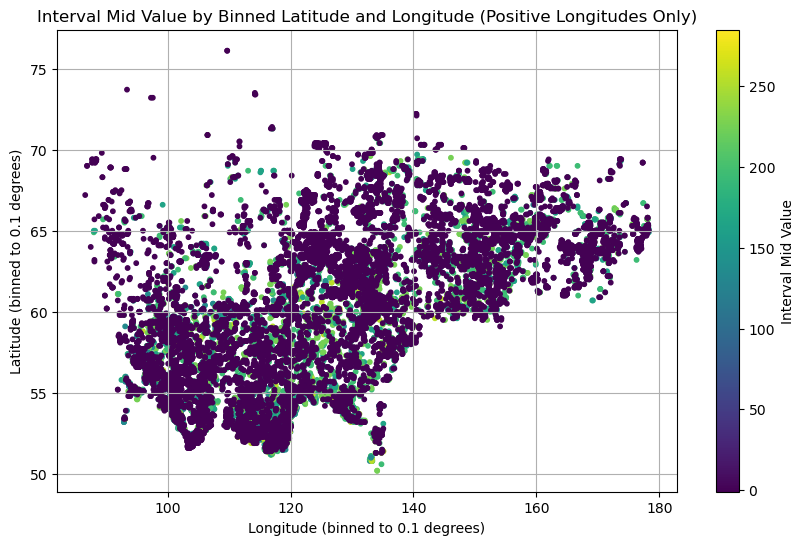

In [15]:
# Bin the lat and lon into 0.1 degree intervals
df_final['lat_bin'] = (df_final['lat'] // 0.1) * 0.1
df_final['lon_bin'] = (df_final['lon'] // 0.1) * 0.1


# Filter out rows with negative longitude values
df_final = df_final[df_final['lon_bin'] >= 0]

# Plotting the interval_mid values by binned lat-lon
plt.figure(figsize=(10, 6))
sc = plt.scatter(df_final['lon_bin'], df_final['lat_bin'], c=df_final['interval_mid'], cmap='viridis', s=10)
plt.colorbar(sc, label='Interval Mid Value')
plt.xlabel('Longitude (binned to 0.1 degrees)')
plt.ylabel('Latitude (binned to 0.1 degrees)')
plt.title('Interval Mid Value by Binned Latitude and Longitude (Positive Longitudes Only)')
plt.grid(True)
plt.show()

In [16]:
df_final.head()

,lat,lon,y,max_column,interval,interval_mid,lat_bin,lon_bin
0,53.969929,113.354408,1,147,120-150,135,53.9,113.3
1,57.517556,136.064717,1,193,180-210,195,57.5,136.0
2,63.207395,117.698930,1,196,180-210,195,63.2,117.6
3,56.211854,99.167674,1,150,150-180,165,56.2,99.1
4,65.936297,137.493038,1,186,180-210,195,65.9,137.4


First find the fraction of the pixels that are being selected by each composite method

Can I plot in matplotlib/seaborn how it is occuring?  Maybe turn to spatial points and do it in GIS? not sure how to do this part